In [1]:
!pip install jiwer

In [2]:
import pandas as pd
import requests as req
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.callbacks import TlensorBoard
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import datetime
import os
import requests

In [3]:
datetimenow = str(datetime.datetime.now()).replace("-", "_").replace(" ", "__").replace(":", "_").split(".")[0]

In [4]:
def upload_data (model_path):
    print("uploading the model", model_path)
    files = {'mdoel_file': open(model_path,'rb')}
    url = "https://api.uneduashqiperine.com/upload_model"
    r = requests.post(url, files=files,)
    print(r)
def post_data(content):
    link = f'http://api.uneduashqiperine.com/add_training_data/{content}'
    return req.get(link)

In [5]:
# data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
# data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
data_path = "/kaggle/input/16000-alb-95-18hrs/dataset_2023-03-30_17"

wavs_path = data_path + "/clips/"
# metadata_path = "/kaggle/input/updated2/metadata.csv"
metadata_path = "/kaggle/input/16000-alb-95-18hrs/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df["normalized_transcription"] = metadata_df["normalized_transcription"].str.lower()
metadata_df.head(3)

,file_name,normalized_transcription
0,report_tv_shtypi_i_dites_dhe_ju_ja_cfare_shkru...,në brendi të gazetës te
1,fjala_serbe_mahnit_behet_burim_fjaleformues_ne...,as amerika
2,agon_channel__a_krasta_show__flaka_krelani_198...,përshtypje


In [6]:
# metadata_df = metadata_df[:100]
split = int(len(metadata_df) * 0.8)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 32187
Size of the validation set: 8047


In [7]:
# The set of characters accepted in the transcription.
# characters = [x for x in "abcçdeëfghijklmnopqrstuvxyz'?! "]
#characters = ["a", "b", "c", "ç", "d", "dh", "e", "ë", "f", "g", "gj", "h", "i", "j", "k", "l", "ll", "m", "n", "nj", "o", "p", "q", "r", "rr", "s", "sh", "t", "th", "u", "v", "x", "xh", "y", "z", "zh", "1", "2", "3", "4", "5", "6", "7", "8", "9", "'", "?", "%", " ", "-"]
characters_init = ["ll","sh", "th", "dh", "zh", "xh", "gj", "nj", "rr", "R", "Ë", "N", "D", "S", "I", "G", "J", "E", " ", "M", "O", "C", "A", "L", "P", "H", "U", "F", "T", "K", "V", "Y", "B", "2", "0", "Z", "Q", "Ç", "W", "1", "-", "X", "3", "9", "%", "4", "6", "5", "8", "7", "."]
characters = [x.lower() for x in characters_init]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'll', 'sh', 'th', 'dh', 'zh', 'xh', 'gj', 'nj', 'rr', 'r', 'ë', 'n', 'd', 's', 'i', 'g', 'j', 'e', ' ', 'm', 'o', 'c', 'a', 'l', 'p', 'h', 'u', 'f', 't', 'k', 'v', 'y', 'b', '2', '0', 'z', 'q', 'ç', 'w', '1', '-', 'x', '3', '9', '%', '4', '6', '5', '8', '7', '.'] (size =52)


In [8]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [9]:
batch_size = 64
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

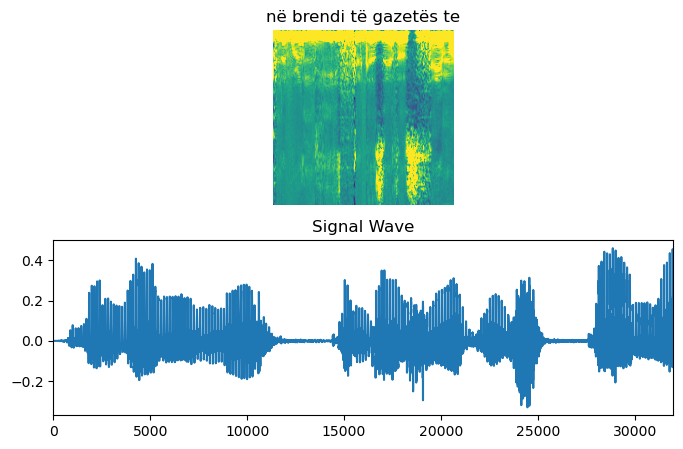

In [10]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [11]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [12]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    
    """Model similar to DeepSpeech2."""
    learning_rate = 1e-4
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [13]:

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    

    def on_epoch_end(self, epoch: int, logs=None):
        
        print("this are the logs", logs)
        
        modelpath = f"/kaggle/working/{datetimenow}_{(epoch+1):02d}-{logs['val_loss']:.2f}.h5"
        print(f"checking if model exist with name: {datetimenow}_{(epoch+1):02d}-{logs['val_loss']:.2f}.h5")
        if (os.path.isfile(modelpath)):
#             upload_data (modelpath)
            print("skipping model upload")
        else: print("model does not exist")

        predictions = []
        targets = []
        
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        wer_logs = "logs/"+ datetimenow + "/wer_logs"
        test_summary_writer = tf.summary.create_file_writer(wer_logs)
        with test_summary_writer.as_default():
            tf.summary.scalar('wer', wer_score, step=(epoch+1))
        
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        predictions_logs = "logs/"+ datetimenow + "/predictions_logs"
        test_summary_writer = tf.summary.create_file_writer(predictions_logs)
        list_with_current = []
        list_with_current.append("-" * 100 + "\n")
        list_with_current.append(f"Word Error Rate: {wer_score:.4f}\n")
        list_with_current.append("-" * 100 + "\n")
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            list_with_current.append(f"Target    : {targets[i]}\n")
            print(f"Prediction: {predictions[i]}")
            list_with_current.append(f"Predictions    : {predictions[i]}\n")
            print("-" * 100)
        list_with_current_str = " ".join(list_with_current)
        with test_summary_writer.as_default():
            text_data = '\n'.join(l.strip() for l in list_with_current_str.splitlines())
            tf.summary.text('markdown_text', text_data, step=epoch)
        jsondata = {"publish_type": 2, "epoch": str(epoch+1), "val_loss": str(logs['val_loss']), "loss": str(logs['loss']), "Word_Error_Rate": str(wer_score), "date": datetimenow}
        post_data(jsondata)
        listasa = str(list_with_current).replace('"', '')
        jsondata = {"publish_type": 3, "list": listasa}
        post_data(jsondata)

        

In [14]:
epochs = 30

In [15]:
def model_information():
    training_len_list = f"Size of the training set: {len(df_train)}" 
    validation_len_list = f"Size of the validation set: {len(df_val)}"
    vocabulary_list = f"The vocabulary is: {char_to_num.get_vocabulary()} "f"(size ={char_to_num.vocabulary_size()})"
    frame_length_list = "frame_length" + f": {frame_length}"
    frame_step_list = "frame_step" + f": {frame_step}"
    fft_length_list = "fft_length" + f": {fft_length}"
    epochs_list = "total epochs" + f": {epochs}"
    full_info_list = [training_len_list, validation_len_list, vocabulary_list, frame_length_list,frame_step_list, fft_length_list, epochs_list]
    return '    ' + '\n    '.join(full_info_list)



# Get model summary as a string
def get_summary_str(model):
    lines = []
    print(lines)
    model.summary(print_fn=lines.append)
    # Add initial spaces to avoid markdown formatting in TensorBoard
    return '    ' + '\n    '.join(lines)

# Write a string to TensorBoard (2.x)
def write_string_summary_v2(writer, s):
    with writer.as_default():
        tf.summary.text('Model configuration', s, step=0)

graphname = "logs/"+ datetimenow + "/model_summary"
infoname = "logs/"+ datetimenow + "/model_information"
# Write model summaries to TensorBoard (2.x)
writer1 = tf.summary.create_file_writer(graphname)
write_string_summary_v2(writer1, get_summary_str(model))
writer2 = tf.summary.create_file_writer(infoname)
write_string_summary_v2(writer2, model_information())

[]


In [16]:
from keras.callbacks import ModelCheckpoint, History
history = History()


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "/kaggle/working/logs/{}".format(datetimenow))


jsondata = {"publish_type": 0, "epochs": epochs, "size_of_train": len(df_train), "size_of_test": len(df_val), "date": datetimenow}
post_data(jsondata)

# Define the number of epochs.

filepath = f"{datetimenow}_" + "{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max', period=2)
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
#     callbacks=[checkpoint, validation_callback, history, tensorboard]
    callbacks=[validation_callback, history, tensorboard_callback]
)

Epoch 1/30
503/503 [==============================] - ETA: 0s - loss: 98.9415this are the logs {'loss': 98.94154357910156, 'val_loss': 95.78013610839844}
checking if model exist with name: 2023_04_04__23_07_33_01-95.78.h5
model does not exist
2/2 [==============================] - 4s 290ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : ka një pjesë militantë të
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : tema
Prediction: 
----------------------------------------------------------------------------------------------------
503/503 [==============================] - 1782s 3s/step - loss: 98.9415 - val_loss: 95.7801
Epoch 2/30
503/503 [==============================] - ETA: 0s - loss: 87.3728this are the logs {'loss'

In [17]:
!zip -r f"{datetimenow}.zip" "/kaggle/working/logs"

  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/ (stored 0%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/ (stored 0%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680666026.72f19ed376e6.23.26.v2 (deflated 10%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680679253.72f19ed376e6.23.46.v2 (deflated 10%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680670073.72f19ed376e6.23.32.v2 (deflated 10%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680673991.72f19ed376e6.23.38.v2 (deflated 9%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680658071.72f19ed376e6.23.14.v2 (deflated 9%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer_logs/events.out.tfevents.1680684609.72f19ed376e6.23.54.v2 (deflated 10%)
  adding: kaggle/working/logs/2023_04_04__23_07_33/wer

In [18]:
print(history.history.keys(), "ss")
print("{epoch:02d}")




dict_keys(['loss', 'val_loss']) ss
{epoch:02d}


In [19]:
# for i, weights in enumerate(weights_list):
#     if i==0 or i==43:
     
#         print(i, "is here")
# #         print(weights)
#     else:
#         model.layers[i].set_weights(weights)
#         print(i)

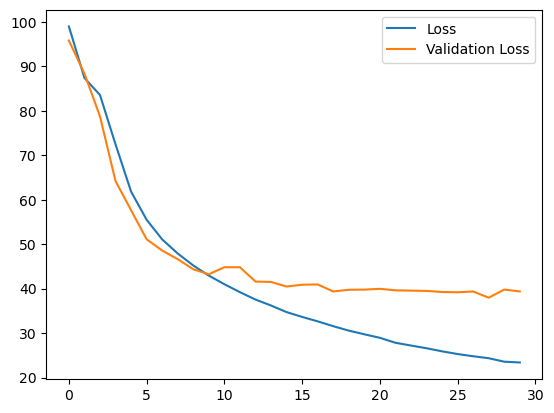

In [20]:
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()
# plt.savefig('loss.png', dpi=400)